Epoch[1/25], G Loss: 2.3694, D Loss: 0.4443, MI Loss: 2.9285


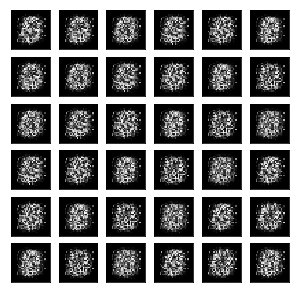

Epoch[2/25], G Loss: 2.5334, D Loss: 0.2534, MI Loss: 1.1653


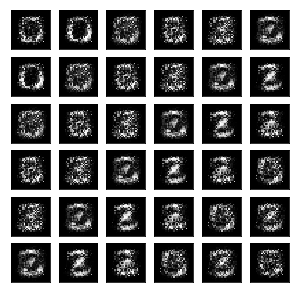

Epoch[3/25], G Loss: 1.9878, D Loss: 0.4325, MI Loss: 0.1370


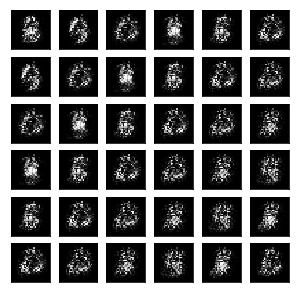

Epoch[4/25], G Loss: 1.8893, D Loss: 0.5019, MI Loss: 0.0857


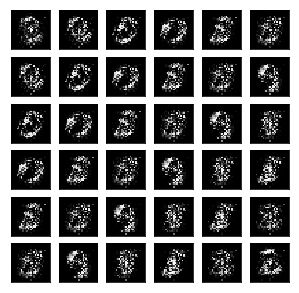

Epoch[5/25], G Loss: 2.0369, D Loss: 0.5349, MI Loss: 0.0821


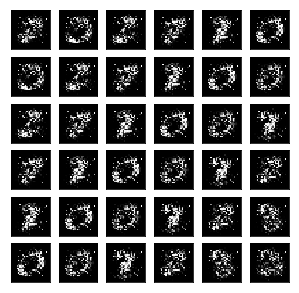

Epoch[6/25], G Loss: 2.1820, D Loss: 0.5178, MI Loss: 0.0810


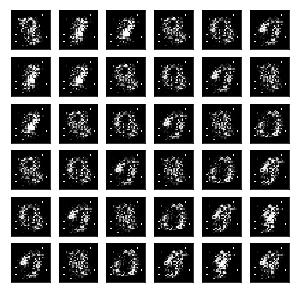

Epoch[7/25], G Loss: 2.4774, D Loss: 0.3701, MI Loss: 0.0779


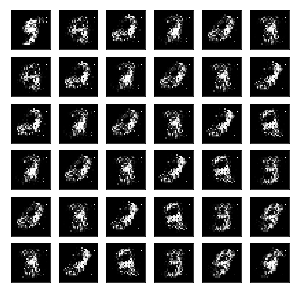

Epoch[8/25], G Loss: 2.5075, D Loss: 0.3967, MI Loss: 0.0790


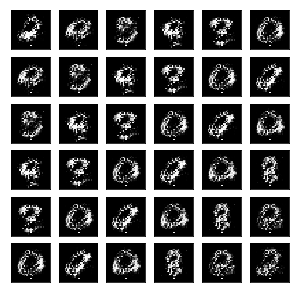

Epoch[9/25], G Loss: 2.4848, D Loss: 0.4066, MI Loss: 0.0844


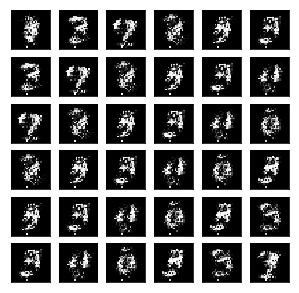

Epoch[10/25], G Loss: 2.5441, D Loss: 0.4371, MI Loss: 0.0901


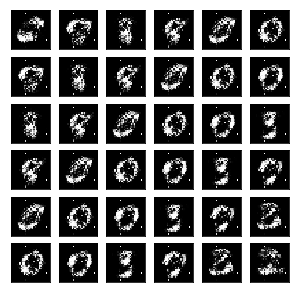

Epoch[11/25], G Loss: 2.6736, D Loss: 0.4004, MI Loss: 0.0995


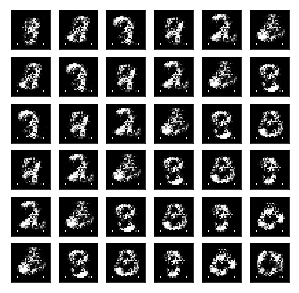

Epoch[12/25], G Loss: 2.7097, D Loss: 0.4109, MI Loss: 0.1111


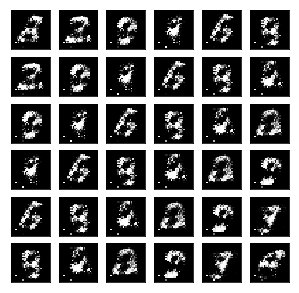

Epoch[13/25], G Loss: 2.7447, D Loss: 0.3363, MI Loss: 0.1251


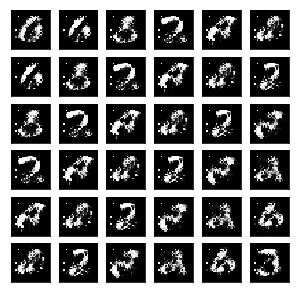

Epoch[14/25], G Loss: 2.8618, D Loss: 0.3687, MI Loss: 0.1379


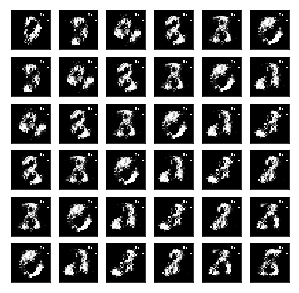

Epoch[15/25], G Loss: 3.0778, D Loss: 0.3015, MI Loss: 0.1483


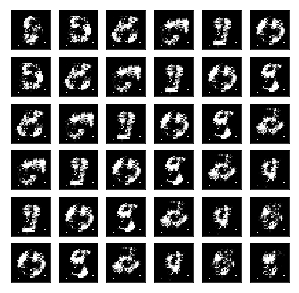

Epoch[16/25], G Loss: 2.9453, D Loss: 0.3340, MI Loss: 0.1481


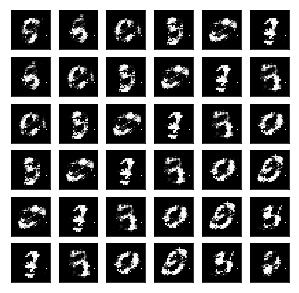

Epoch[17/25], G Loss: 2.7835, D Loss: 0.3352, MI Loss: 0.1560


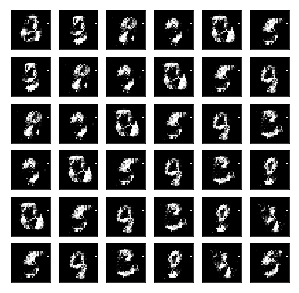

Epoch[18/25], G Loss: 3.6664, D Loss: 0.2235, MI Loss: 0.1841


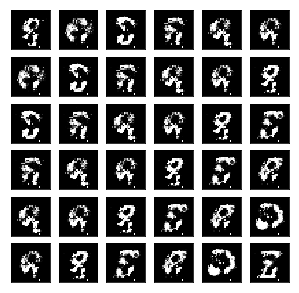

Epoch[19/25], G Loss: 3.4905, D Loss: 0.3568, MI Loss: 0.1973


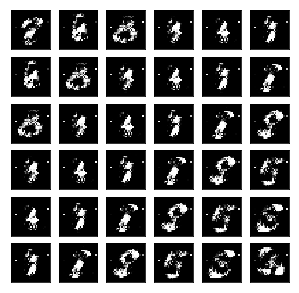

Epoch[20/25], G Loss: 3.2035, D Loss: 0.2930, MI Loss: 0.1946


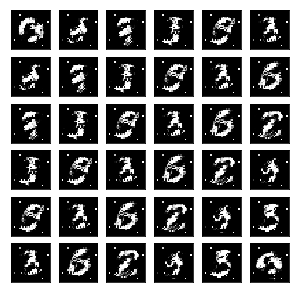

Epoch[21/25], G Loss: 4.1646, D Loss: 0.1828, MI Loss: 0.2173


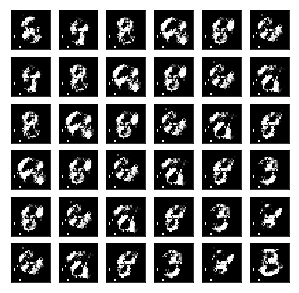

Epoch[22/25], G Loss: 3.5318, D Loss: 0.3230, MI Loss: 0.2116


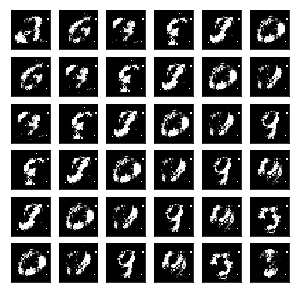

Epoch[23/25], G Loss: 3.9387, D Loss: 0.1626, MI Loss: 0.2296


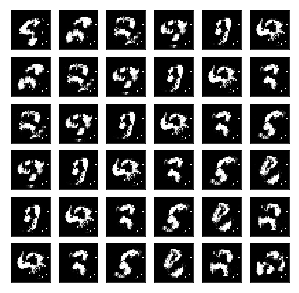

Epoch[24/25], G Loss: 4.3318, D Loss: 0.2575, MI Loss: 0.2618


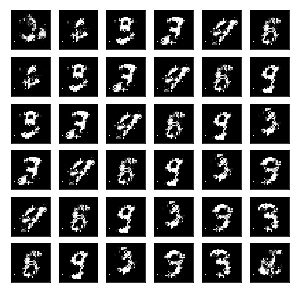

Epoch[25/25], G Loss: 3.4156, D Loss: 0.3114, MI Loss: 0.2424


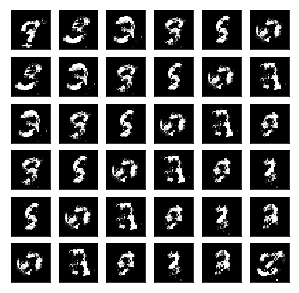

In [277]:
""" (InfoGAN)

From the paper:
"In this paper, we present a simple modification to the generative adversarial 
network objective that encourages it to learn interpretable and meaningful 
representations. We do so by maximizing the mutual information between a fixed 
small subset of the GAN’s noise variables and the observations, which turns out 
to be relatively straightforward. Despite its simplicity, we found our method to be
surprisingly effective: it was able to discover highly semantic and meaningful 
hidden representations on a number of image datasets: digits (MNIST), faces (CelebA), 
and house numbers (SVHN). ""

The Generator input is split into two parts: a traditional "noise" vector (z)
and a latent "code” vector (c) that targets the salient structured semantic features of 
the data distribution. These vectors are made meaningful by maximizing the mutual 
information lower bound between c and the G(c, z). Since mutual information is
inefficient to compute directly, we estimate it using an auxiliary network Q.

The auxiliary network Q(c|x) approximates P(c|x), the true posterior. We use this to 
compute the mutual information by sampling c from our assumed prior P(c), sampling a 
noise vector z, using them both to sample  x ~ G(c, z), and then passing x to Q(c|x). 
We then use Q(c|x) to maximize the mutual information between c and G(z, c) and 
backpropagate its estimate back to both G and Q.

https://arxiv.org/pdf/1606.03657.pdf

"""

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
# train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise and latent variables, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim, disc_dim, cont_dim):
        super().__init__()
        self.linear = nn.Linear(z_dim + disc_dim + cont_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = torch.sigmoid(self.generate(activated))
        return generation


class Discriminator(nn.Module):
    """ Discriminator. Input is an image (real or generated), output is P(generated), 
    continuous latent variables, discrete latent variables.
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        
        self.__dict__.update(locals())

        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminator = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = torch.sigmoid(self.discriminator(activated))
        return discrimination

    
class Q(nn.Module):
    """ Auxiliary network Q(c|x) that approximates P(c|x), the true posterior.
    Input is an image, output are latent variables.
    """
    def __init__(self, image_size, hidden_dim, disc_dim, cont_dim):
        super().__init__()

        self.__dict__.update(locals())

        self.linear = nn.Linear(image_size, hidden_dim)
        self.inference = nn.Linear(hidden_dim, disc_dim+cont_dim)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        inferred = self.inference(activated)
        discrete, continuous = inferred[:, :self.disc_dim], inferred[:, self.disc_dim:]
        return discrete, continuous


class InfoGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, disc_dim, cont_dim, output_dim=1):
        super().__init__()
        
        self.__dict__.update(locals())
        
        self.G = Generator(image_size, hidden_dim, z_dim, disc_dim, cont_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        self.Q = Q(image_size, hidden_dim, disc_dim, cont_dim)

    
class InfoGANTrainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []
        self.MIlosses = []
        
        self.viz = viz
            
    def train(self, num_epochs, G_lr=2e-4, D_lr=2e-4, D_steps=1):
        """ Train a vanilla GAN using the non-saturating gradients loss for the generator. 
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 2e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 2e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 1)
        """
        # Initialize optimizers
        parameters = {'D': [p for p in self.model.D.parameters() if p.requires_grad],
                      'G': [p for p in self.model.G.parameters() if p.requires_grad],
                      'Q': [p for p in self.model.Q.parameters() if p.requires_grad]}
        
        G_optimizer = optim.Adam(params=parameters['G'], lr=G_lr)
        D_optimizer = optim.Adam(params=parameters['D'], lr=D_lr)
        MI_optimizer = optim.Adam(params=(parameters['G']+parameters['Q']), lr=G_lr)
    
        # Approximate steps/epoch given D_steps per epoch 
        # --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses, MI_losses = [], [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Learn to discriminate between real and generated images
                    D_loss = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                                                        
                # So that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Learn to generate images that fool the discriminator
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
                
                # TRAINING Q: Zero out gradients for Q
                MI_optimizer.zero_grad()
                
                # Learn to estimate Mutual Information
                MI_loss = self.train_Q(images)

                # Update parameters
                MI_losses.append(MI_loss.item())
                MI_loss.backward()
                MI_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
            self.MIlosses.extend(MI_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f, MI Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), 
                     np.mean(D_losses), np.mean(MI_losses))) 
            self.num_epochs = epoch
            
            # Visualize generator progress
            self.generate_images(epoch)
            
            if self.viz:
                plt.show()
                
    def train_D(self, images):
        """ Run 1 step of training for discriminator

        Input:
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: non-saturing loss for discriminator
            -E[log(D(x))] - E[log(1 - D(G(c, z)))]
        """    
        # Generate labels (ones indicate real images, zeros indicate generated)
        X_labels = to_cuda(torch.ones(images.shape[0], 1)) 
        G_labels = to_cuda(torch.zeros(images.shape[0], 1)) 
        
        # Classify the real batch images, get the loss for these 
        DX_score = self.model.D(images)
        DX_loss = F.binary_cross_entropy(DX_score, X_labels)
        
        # Sample noise z, generate output G(c, z)
        noise = self.compute_noise(images.shape[0], self.model.z_dim, 
                                   self.model.disc_dim, self.model.cont_dim)
        G_output = self.model.G(noise)
        
        # Classify the fake batch images, get the loss for these using sigmoid cross entropy
        DG_score = self.model.D(G_output)
        DG_loss = F.binary_cross_entropy(DG_score, G_labels)
        
        # Compute vanilla (original paper) D loss
        D_loss = DX_loss + DG_loss
        
        return D_loss
    
    def train_G(self, images):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: non-saturating loss for how well G(z) fools D
            -E[log(D(G(c, z)))]
        """        
        # Generate labels for the generator batch images (all 0, since they are fake)
        G_labels = to_cuda(torch.ones(images.shape[0], 1)) 
        
        # Get noise (denoted z), classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], self.model.z_dim, 
                                   self.model.disc_dim, self.model.cont_dim, c=None) # c=[c1, c2], z
        G_output = self.model.G(noise) # G(c, z)
        DG_score = self.model.D(G_output) # D(G(c, z))
        
        # Compute the non-saturating loss for how D did versus the generations of G using sigmoid cross entropy
        G_loss = F.binary_cross_entropy(DG_score, G_labels)
        
        return G_loss
    
    def train_Q(self, images, LAMBDA=1):
        """ Run 1 step of training for auxiliary approximator network
        
        Input:
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            MI_loss: Approximation of mutual information 
            λI(c, G(c, z)) where I is the mutual information between our prior and
            the GAN distribution
        """
        # Generate labels for the generator batch images (all 0, since they are fake)
        G_labels = to_cuda(torch.zeros(images.shape[0], 1)) 
        
        # Sample noise z, generate output G(c, z)
        noise = self.compute_noise(images.shape[0], self.model.z_dim, 
                                   self.model.disc_dim, self.model.cont_dim)
        
        # Transform noise using G
        G_output = self.model.G(noise)
        
        # Approximate true posterior for categorical, Gaussian latent variables
        Q_discrete, Q_continuous = self.model.Q(G_output)
        
        # Compute mutual information loss
        # Discrete component
        discrete_target = noise[:, self.model.z_dim:self.model.z_dim+self.model.disc_dim]
        disc_loss = F.cross_entropy(Q_discrete, torch.max(discrete_target, 1)[1])
        
        # Continuous component
        continuous_target = noise[:, self.model.z_dim+self.model.disc_dim:]
        cont_loss = F.mse_loss(Q_continuous, continuous_target)
        
        # Sum it up
        MI_loss = LAMBDA * (disc_loss + cont_loss)
        
        return MI_loss
        
    def compute_noise(self, batch_size, z_dim, disc_dim, cont_dim, c=None):
        """ Compute random noise for the generator to learn to make images 
        OPTIONAL: set c to explore latent dimension space. 
        """
        
        # Noise vector (z)
        z = torch.randn(batch_size, z_dim)
        
        # Uniformly distributed categorical latent variables (c1)
        disc_c = torch.zeros((batch_size, disc_dim))
        if c is not None:
            categorical = int(c)*torch.ones((batch_size,), dtype=torch.long)
        else:
            categorical = torch.randint(0, disc_dim, (batch_size,), dtype=torch.long)
        disc_c[range(batch_size), categorical] = 1
        
        # Gaussian continuous latent variables (c2)
        cont_c = torch.randn(batch_size, cont_dim)
        
        return to_cuda(torch.cat((z, disc_c, cont_c), dim=1))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def generate_images(self, epoch, num_outputs=36, save=True, c=None):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim, 
                                   self.model.disc_dim, self.model.cont_dim, c=c) 
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        plt.close()
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data, 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        # Set style, figure size
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        # Plot Discriminator loss in red, Generator loss in green
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Dlosses, 'r')
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Glosses, 'g')
        
        # Add legend, title
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = InfoGAN(image_size=784, 
                hidden_dim=256, 
                z_dim=128,
                disc_dim=10,
                cont_dim=10)

trainer = InfoGANTrainer(model=model, 
                         train_iter=train_iter, 
                         val_iter=val_iter, 
                         test_iter=test_iter,
                         viz=True)

trainer.train(num_epochs=25, 
              G_lr=2e-4,
              D_lr=2e-4, 
              D_steps=1)

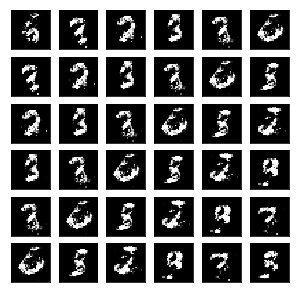

In [287]:
# c does not innately correspond to the digit being produced
# These seem to be 3. They would be crisper given a stronger GAN architecture.
trainer.generate_images(epoch=3, num_outputs=36, save=False, c=6)

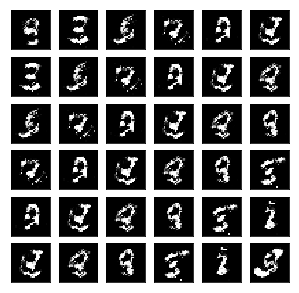

In [286]:
# These seem to be 9
trainer.generate_images(epoch=3, num_outputs=36, save=False, c=7)